# Analyzing

In this jupyter notebook the dataframe obtained from 'code2_cleaning' will be analized. The objectives are:

- Mosquito per day obtention.

- API (Application Programming Interface) use to get climate data. API is a server that you can use to retrieve and send data to using code. APIs are most commonly used to retrieve data.

- Explain some basic results.

In [2]:
# Data treatment
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from datetime import date, datetime
import holidays
import requests #To check if an API link works
from IPython.core.interactiveshell import InteractiveShell #Show more than one output per cell
InteractiveShell.ast_node_interactivity = "all"
import ast

# API for accessing open weather and climate data
# ------------------------------------------------------------------------------
from meteostat import Point, Daily

# Graphs
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings configuration
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

# Library to create pickle files.
# ------------------------------------------------------------------------------
import pickle
import os

# Progress bar
# ------------------------------------------------------------------------------
from tqdm import tqdm

# Put a pause between API calls
# ------------------------------------------------------------------------------
import time

In [3]:
# To show all the columns of our dataframe.
pd.options.display.max_columns=None

In [4]:
# Create the first dataframe containing the data from the csv obtained from Gbif.
df_0 = pd.read_csv('../data/mosquito1_clean.csv', index_col=0)

# Check the first three rows to see how this dataframe looks like.
df_0.head(3)

,event_date,year,month,day,country_code,latitude,longitude,witness,issue
0,2022-11-04,2022,11,4,ES,41.51019,2.24589,Roger Eritja,CONTINENT_DERIVED_FROM_COORDINATES
1,2021-08-27,2021,8,27,IT,44.40289,8.98775,Karin Bakran-Lebl;Ana Klobucar;UNIROMA1;Roger ...,CONTINENT_DERIVED_FROM_COORDINATES
3,2022-08-11,2022,8,11,IT,41.70922,12.78512,UNIROMA1;Eleonora Longo;Francesco Severini;Rog...,CONTINENT_DERIVED_FROM_COORDINATES


In [5]:
print(f'This DataFrame has {df_0.shape[0]} rows and {df_0.shape[1]} columns.')

This DataFrame has 14512 rows and 9 columns.


## 1. Get weather information with API

The method to get weather information of each row at that date will be with the **Meteostat Python library**. It provides a simple API for accessing open weather and climate data using Pandas. The historical observations and statistics are collected by Meteostat from different public interfaces, most of which are governmental.

In [6]:
# Create a small copy of the dataframe to make some test before using Meteostat on the whole dataframe.
df_test1=df_0.head(10)
df_test1

,event_date,year,month,day,country_code,latitude,longitude,witness,issue
0,2022-11-04,2022,11,4,ES,41.51019,2.24589,Roger Eritja,CONTINENT_DERIVED_FROM_COORDINATES
1,2021-08-27,2021,8,27,IT,44.40289,8.98775,Karin Bakran-Lebl;Ana Klobucar;UNIROMA1;Roger ...,CONTINENT_DERIVED_FROM_COORDINATES
3,2022-08-11,2022,8,11,IT,41.70922,12.78512,UNIROMA1;Eleonora Longo;Francesco Severini;Rog...,CONTINENT_DERIVED_FROM_COORDINATES
4,2022-06-27,2022,6,27,HU,47.46323,19.17698,Anonymous expert;Kornélia Kurucz;Gábor Kemenes...,CONTINENT_DERIVED_FROM_COORDINATES
5,2021-10-20,2021,10,20,ES,39.43645,2.75412,Maria Angeles Puig;Mikel Bengoa Paulis;Ignacio...,CONTINENT_DERIVED_FROM_COORDINATES
7,2022-08-26,2022,8,26,IT,43.76617,11.27971,UNIROMA1;Roger Eritja,CONTINENT_DERIVED_FROM_COORDINATES
8,2022-06-22,2022,6,22,IT,40.30343,17.72688,Roger Eritja;UNIROMA1,CONTINENT_DERIVED_FROM_COORDINATES
9,2022-08-16,2022,8,16,ES,37.39345,-6.08236,Isis Sanpera-Calbet;Mikel Alexander González;D...,CONTINENT_DERIVED_FROM_COORDINATES
10,2022-08-13,2022,8,13,IT,45.57203,12.10044,UNIROMA1;Eleonora Longo;Francesco Severini;Rog...,CONTINENT_DERIVED_FROM_COORDINATES
12,2022-06-22,2022,6,22,IT,41.83784,12.69665,Roger Eritja;UNIROMA1,CONTINENT_DERIVED_FROM_COORDINATES


In [7]:
# Create a dataframe and a for loop to test if it works before coding it inside a function.
datay_dict={'event_date':['1111-11-11'],'latitude':[11.11111],'longitude':[11.11111],
                'time':['1111-11-11'],'tavg':[11.1],'tmin':[11.1],'tmax':[11.1],'prcp':[1.1],
                'snow':[1.1],'wdir':[1.1],'wspd':[1.1],'wpgt':[1.1],'pres':[1.1],'tsun':[1.1]}
datay=pd.DataFrame.from_dict(datay_dict)

for i in tqdm(range(len(datay))):
        date=datay.iloc[i]['event_date']
        latitude=datay.iloc[i]['latitude']
        longitude=datay.iloc[i]['longitude']
        datay.loc[i]={'event_date':date,'latitude':latitude,'longitude':longitude,
                'time':'2222-22-22','tavg':22.2,'tmin':22.2,'tmax':22.2,'prcp':2.2,
                'snow':2.2,'wdir':2.2,'wspd':2.2,'wpgt':2.2,'pres':2.2,'tsun':2.2}
datay

100%|██████████| 1/1 [00:00<00:00, 266.12it/s]


,event_date,latitude,longitude,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,1111-11-11,11.11111,11.11111,2222-22-22,22.2,22.2,22.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2


In [8]:
# Define funtion:
def get_weather(df):
    # Function to obtain past weather and climate data

    dataz_dict={'event_date2':['1111-11-11'],'latitude2':[11.11111],'longitude2':[11.11111],
                'time':['1111-11-11'],'tavg':[11.1],'tmin':[11.1],'tmax':[11.1],'prcp':[1.1],
                'snow':[1.1],'wdir':[1.1],'wspd':[1.1],'wpgt':[1.1],'pres':[1.1],'tsun':[1.1]}
    dataz=pd.DataFrame.from_dict(dataz_dict)

    # Create a for loop to go row by row and use the API for the whole Dataframe.
    # tqdm() is used to have a progress bar.
    for i in tqdm(range(len(df))):
        date=df.iloc[i]['event_date']
        latitude=df.iloc[i]['latitude']
        longitude=df.iloc[i]['longitude']

        #API use:
        # Set time period
        start = pd.to_datetime(date, format='%Y-%m-%d')
        end = pd.to_datetime(date, format='%Y-%m-%d')
    
        # Create Point (Automatically select weather stations by geographic location)
        location = Point(latitude, longitude)
           
        # Get daily data
        data = Daily(location, start, end)
        data = data.fetch().reset_index()
        # try & except is used because some rows have problems to get the weather data from the API.
        # Those rows will have null values.
        try:
            dataz.loc[i]={'event_date2':date,'latitude2':latitude,'longitude2':longitude,
                'time':data.iloc[0]['time'],'tavg':data.iloc[0]['tavg'],'tmin':data.iloc[0]['tmin'],
                'tmax':data.iloc[0]['tmax'],'prcp':data.iloc[0]['prcp'],'snow':data.iloc[0]['snow'],
                'wdir':data.iloc[0]['wdir'],'wspd':data.iloc[0]['wspd'],'wpgt':data.iloc[0]['wpgt'],
                'pres':data.iloc[0]['pres'],'tsun':data.iloc[0]['tsun']}
            
            time.sleep(0.05)    #time.sleep() is used to stop the for lood for 0.01seconds, so
                                # the API does not "get overwhelmed".
        except:
            dataz.loc[i]={'event_date2':date,'latitude2':latitude,'longitude2':longitude,
                'time':np.nan,'tavg':np.nan,'tmin':np.nan,
                'tmax':np.nan,'prcp':np.nan,'snow':np.nan,
                'wdir':np.nan,'wspd':np.nan,'wpgt':np.nan,
                'pres':np.nan,'tsun':np.nan}

            time.sleep(0.05)

    return dataz

In [9]:
# Try funcion 'get_weather' on a small dataframe.
df_test1_meteo=get_weather(df_test1)
df_test1_meteo

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


,event_date2,latitude2,longitude2,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2022-11-04,41.51019,2.24589,2022-11-04 00:00:00,15.4,11.0,20.0,0.0,NaN,271.0,19.5,42.6,1013.8,NaN
1,2021-08-27,44.40289,8.98775,2021-08-27 00:00:00,25.0,23.0,28.1,0.3,NaN,68.0,13.8,27.8,1007.5,NaN
2,2022-08-11,41.70922,12.78512,2022-08-11 00:00:00,27.7,22.0,32.0,1.1,NaN,173.0,9.0,NaN,1013.9,NaN
3,2022-06-27,47.46323,19.17698,2022-06-27 00:00:00,26.6,17.7,33.1,0.0,NaN,89.0,6.2,38.0,1016.6,NaN
4,2021-10-20,39.43645,2.75412,2021-10-20 00:00:00,18.3,17.7,24.8,0.0,NaN,83.0,7.1,NaN,1023.5,NaN
5,2022-08-26,43.76617,11.27971,2022-08-26 00:00:00,26.1,19.9,33.3,0.3,NaN,34.0,5.4,18.5,1010.9,NaN
6,2022-06-22,40.30343,17.72688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2022-08-16,37.39345,-6.08236,2022-08-16 00:00:00,24.9,18.7,30.9,0.0,NaN,256.0,14.2,40.8,1011.3,NaN
8,2022-08-13,45.57203,12.10044,2022-08-13 00:00:00,23.1,16.0,28.3,0.0,NaN,31.0,7.2,NaN,1013.0,NaN
9,2022-06-22,41.83784,12.69665,2022-06-22 00:00:00,27.5,20.1,33.8,0.0,NaN,176.0,10.1,NaN,1014.0,NaN


In [12]:
# Get weather data on the big dataframe using the function created
df_0_meteo=get_weather(df_0)
df_0_meteo.head(10)

100%|██████████| 14512/14512 [27:22<00:00,  8.83it/s]


,event_date2,latitude2,longitude2,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2022-11-04,41.51019,2.24589,2022-11-04 00:00:00,15.4,11.0,20.0,0.0,NaN,271.0,19.5,42.6,1013.8,NaN
1,2021-08-27,44.40289,8.98775,2021-08-27 00:00:00,25.0,23.0,28.1,0.3,NaN,68.0,13.8,27.8,1007.5,NaN
2,2022-08-11,41.70922,12.78512,2022-08-11 00:00:00,27.7,22.0,32.0,1.1,NaN,173.0,9.0,NaN,1013.9,NaN
3,2022-06-27,47.46323,19.17698,2022-06-27 00:00:00,26.6,17.7,33.1,0.0,NaN,89.0,6.2,38.0,1016.6,NaN
4,2021-10-20,39.43645,2.75412,2021-10-20 00:00:00,18.3,17.7,24.8,0.0,NaN,83.0,7.1,NaN,1023.5,NaN
5,2022-08-26,43.76617,11.27971,2022-08-26 00:00:00,26.1,19.9,33.3,0.3,NaN,34.0,5.4,18.5,1010.9,NaN
6,2022-06-22,40.30343,17.72688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2022-08-16,37.39345,-6.08236,2022-08-16 00:00:00,24.9,18.7,30.9,0.0,NaN,256.0,14.2,40.8,1011.3,NaN
8,2022-08-13,45.57203,12.10044,2022-08-13 00:00:00,23.1,16.0,28.3,0.0,NaN,31.0,7.2,NaN,1013.0,NaN
9,2022-06-22,41.83784,12.69665,2022-06-22 00:00:00,27.5,20.1,33.8,0.0,NaN,176.0,10.1,NaN,1014.0,NaN


Meaning of each column created with Meteostat:

| Column  | Description                                                                         | Type       |
|---------|-------------------------------------------------------------------------------------|------------|
| time    | The date                                                                            | Datetime64 |
| tavg    | The average air temperature in °C                                                   | Float64    |
| tmin    | The minimum air temperature in °C                                                   | Float64    |
| tmax    | The maximum air temperature in °C                                                   | Float64    |
| prcp    | The daily precipitation total in mm                                                 | Float64    |
| snow    | The snow depth in mm                                                                | Float64    |
| wdir    | The average wind direction in degrees (°)                                           | Float64    |
| wspd    | The average wind speed in km/h                                                      | Float64    |
| wpgt    | The peak wind gust in km/h                                                          | Float64    |
| pres    | The average sea-level air pressure in hPa                                           | Float64    |
| tsun    | The daily sunshine total in minutes (m)                                             | Float64    |

In [13]:
# Make copy of the dataframes and reset their index to avoid trouble.
df_0_index=df_0.copy()
df_0_index=df_0_index.reset_index()
df_0_index.tail(3)

,index,event_date,year,month,day,country_code,latitude,longitude,witness,issue
14509,24785,2016-08-18,2016,8,18,US,40.67558,-73.91940,Ignacio Ruiz-Arrondo;Rosario Melero-Alcíbar;Ro...,CONTINENT_DERIVED_FROM_COORDINATES
14510,24786,2015-07-31,2015,7,31,ES,41.51405,2.24227,Mikel Bengoa Paulis;Roger Eritja;Mosquito Aler...,CONTINENT_DERIVED_FROM_COORDINATES
14511,24787,2016-11-04,2016,11,4,ES,38.01097,-0.66220,Rosario Melero-Alcíbar;Ignacio Ruiz-Arrondo;Mi...,CONTINENT_DERIVED_FROM_COORDINATES


In [14]:
df_0_meteo_index=df_0_meteo.copy()
df_0_meteo_index=df_0_meteo_index.reset_index()
df_0_meteo_index.tail(3)

,index,event_date2,latitude2,longitude2,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
14509,14509,2016-08-18,40.67558,-73.91940,2016-08-18 00:00:00,26.5,22.8,30.6,2.5,0.0,NaN,9.0,NaN,1015.0,NaN
14510,14510,2015-07-31,41.51405,2.24227,2015-07-31 00:00:00,24.4,21.2,26.9,13.4,NaN,NaN,12.0,NaN,1012.1,NaN
14511,14511,2016-11-04,38.01097,-0.66220,2016-11-04 00:00:00,20.2,15.3,24.3,0.0,NaN,354.0,7.0,NaN,1016.8,NaN


In [15]:
# Check both dataframes info.
df_0_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14512 entries, 0 to 14511
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         14512 non-null  int64  
 1   event_date    14512 non-null  object 
 2   year          14512 non-null  int64  
 3   month         14512 non-null  int64  
 4   day           14512 non-null  int64  
 5   country_code  14512 non-null  object 
 6   latitude      14512 non-null  float64
 7   longitude     14512 non-null  float64
 8   witness       14512 non-null  object 
 9   issue         14512 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 1.1+ MB


In [16]:
df_0_meteo_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14512 entries, 0 to 14511
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        14512 non-null  int64  
 1   event_date2  14512 non-null  object 
 2   latitude2    14512 non-null  float64
 3   longitude2   14512 non-null  float64
 4   time         12485 non-null  object 
 5   tavg         12480 non-null  float64
 6   tmin         12454 non-null  float64
 7   tmax         12453 non-null  float64
 8   prcp         11072 non-null  float64
 9   snow         76 non-null     float64
 10  wdir         10404 non-null  float64
 11  wspd         11992 non-null  float64
 12  wpgt         4882 non-null   float64
 13  pres         11384 non-null  float64
 14  tsun         1 non-null      float64
dtypes: float64(12), int64(1), object(2)
memory usage: 1.7+ MB


In [17]:
# Join both dataframes in one in order to have meteo information in the same row as mosquito information.
df_1=pd.concat([df_0_index,df_0_meteo_index],axis=1,ignore_index=False)
df_1.head(3)

,index,event_date,year,month,day,country_code,latitude,longitude,witness,issue,index,event_date2,latitude2,longitude2,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,0,2022-11-04,2022,11,4,ES,41.51019,2.24589,Roger Eritja,CONTINENT_DERIVED_FROM_COORDINATES,0,2022-11-04,41.51019,2.24589,2022-11-04 00:00:00,15.4,11.0,20.0,0.0,NaN,271.0,19.5,42.6,1013.8,NaN
1,1,2021-08-27,2021,8,27,IT,44.40289,8.98775,Karin Bakran-Lebl;Ana Klobucar;UNIROMA1;Roger ...,CONTINENT_DERIVED_FROM_COORDINATES,1,2021-08-27,44.40289,8.98775,2021-08-27 00:00:00,25.0,23.0,28.1,0.3,NaN,68.0,13.8,27.8,1007.5,NaN
2,3,2022-08-11,2022,8,11,IT,41.70922,12.78512,UNIROMA1;Eleonora Longo;Francesco Severini;Rog...,CONTINENT_DERIVED_FROM_COORDINATES,2,2022-08-11,41.70922,12.78512,2022-08-11 00:00:00,27.7,22.0,32.0,1.1,NaN,173.0,9.0,NaN,1013.9,NaN


In [18]:
print(f'The dataframe created with mosquito and meteo information has {df_1.shape[0]} rows and {df_1.shape[1]} columns.')

The dataframe created with mosquito and meteo information has 14512 rows and 25 columns.


In [20]:
df_1.to_csv("../data/mosquito1_meteo.csv")

## 2. Clean obtained dataframe

### 2.1. Check concat

In [ ]:
# Change the column 'event_date' to datetime format.
df_1['new_event_date'] = pd.to_datetime(df_1['event_date'], format='%Y-%m-%d')
df_1.head(3)

,index,event_date,year,month,day,country_code,latitude,longitude,witness,issue,index,event_date2,latitude2,longitude2,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,new_event_date
0,0,2022-11-04,2022,11,4,ES,41.51019,2.24589,Roger Eritja,CONTINENT_DERIVED_FROM_COORDINATES,0,2022-11-04,41.51019,2.24589,2022-11-04 00:00:00,15.4,11.0,20.0,0.0,NaN,271.0,19.5,42.6,1013.8,NaN,2022-11-04
1,1,2021-08-27,2021,8,27,IT,44.40289,8.98775,Karin Bakran-Lebl;Ana Klobucar;UNIROMA1;Roger ...,CONTINENT_DERIVED_FROM_COORDINATES,1,2021-08-27,44.40289,8.98775,2021-08-27 00:00:00,25.0,23.0,28.1,0.3,NaN,68.0,13.8,27.8,1007.5,NaN,2021-08-27
2,3,2022-08-11,2022,8,11,IT,41.70922,12.78512,UNIROMA1;Eleonora Longo;Francesco Severini;Rog...,CONTINENT_DERIVED_FROM_COORDINATES,2,2022-08-11,41.70922,12.78512,2022-08-11 00:00:00,27.7,22.0,32.0,1.1,NaN,173.0,9.0,NaN,1013.9,NaN,2022-08-11


In [ ]:
# Change the column 'event_date' to datetime format.
df_1['new_event_date2'] = pd.to_datetime(df_1['event_date2'], format='%Y-%m-%d')
df_1.head(3)

,index,event_date,year,month,day,country_code,latitude,longitude,witness,issue,index,event_date2,latitude2,longitude2,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,new_event_date,new_event_date2
0,0,2022-11-04,2022,11,4,ES,41.51019,2.24589,Roger Eritja,CONTINENT_DERIVED_FROM_COORDINATES,0,2022-11-04,41.51019,2.24589,2022-11-04 00:00:00,15.4,11.0,20.0,0.0,NaN,271.0,19.5,42.6,1013.8,NaN,2022-11-04,2022-11-04
1,1,2021-08-27,2021,8,27,IT,44.40289,8.98775,Karin Bakran-Lebl;Ana Klobucar;UNIROMA1;Roger ...,CONTINENT_DERIVED_FROM_COORDINATES,1,2021-08-27,44.40289,8.98775,2021-08-27 00:00:00,25.0,23.0,28.1,0.3,NaN,68.0,13.8,27.8,1007.5,NaN,2021-08-27,2021-08-27
2,3,2022-08-11,2022,8,11,IT,41.70922,12.78512,UNIROMA1;Eleonora Longo;Francesco Severini;Rog...,CONTINENT_DERIVED_FROM_COORDINATES,2,2022-08-11,41.70922,12.78512,2022-08-11 00:00:00,27.7,22.0,32.0,1.1,NaN,173.0,9.0,NaN,1013.9,NaN,2022-08-11,2022-08-11


In [ ]:
# Check the type of information that each column has.
df_1.dtypes

index                       int64
event_date                 object
year                        int64
month                       int64
day                         int64
country_code               object
latitude                  float64
longitude                 float64
witness                    object
issue                      object
index                       int64
event_date2                object
latitude2                 float64
longitude2                float64
time                       object
tavg                      float64
tmin                      float64
tmax                      float64
prcp                      float64
snow                      float64
wdir                      float64
wspd                      float64
wpgt                      float64
pres                      float64
tsun                      float64
new_event_date     datetime64[ns]
new_event_date2    datetime64[ns]
dtype: object

In [ ]:
# Check if column 'new_check_date' has the same information as 'new_event_date'.
df_1['same_date'] = np.where(df_1['new_event_date']==df_1['new_event_date2'], True, False)
df_1.head(3)

,index,event_date,year,month,day,country_code,latitude,longitude,witness,issue,index,event_date2,latitude2,longitude2,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,new_event_date,new_event_date2,same_date
0,0,2022-11-04,2022,11,4,ES,41.51019,2.24589,Roger Eritja,CONTINENT_DERIVED_FROM_COORDINATES,0,2022-11-04,41.51019,2.24589,2022-11-04 00:00:00,15.4,11.0,20.0,0.0,NaN,271.0,19.5,42.6,1013.8,NaN,2022-11-04,2022-11-04,True
1,1,2021-08-27,2021,8,27,IT,44.40289,8.98775,Karin Bakran-Lebl;Ana Klobucar;UNIROMA1;Roger ...,CONTINENT_DERIVED_FROM_COORDINATES,1,2021-08-27,44.40289,8.98775,2021-08-27 00:00:00,25.0,23.0,28.1,0.3,NaN,68.0,13.8,27.8,1007.5,NaN,2021-08-27,2021-08-27,True
2,3,2022-08-11,2022,8,11,IT,41.70922,12.78512,UNIROMA1;Eleonora Longo;Francesco Severini;Rog...,CONTINENT_DERIVED_FROM_COORDINATES,2,2022-08-11,41.70922,12.78512,2022-08-11 00:00:00,27.7,22.0,32.0,1.1,NaN,173.0,9.0,NaN,1013.9,NaN,2022-08-11,2022-08-11,True


In [ ]:
# Check if all the rows have True as value in column 'same_date'.
df_1['same_date'].value_counts()

True    14512
Name: same_date, dtype: int64

All values are True, so all the rows have the same date on the same row.

In [ ]:
# Check if column 'latitude' has the same information as 'latitude2'.
df_1['same_latitude'] = np.where(df_1['latitude']==df_1['latitude2'], True, False)
# Check if all the rows have True as value in column 'same_date'.
df_1['same_latitude'].value_counts()

True    14512
Name: same_latitude, dtype: int64

All values are True, so all the rows have the same latitude on the same row.

In [ ]:
# Check if column 'latitude' has the same information as 'latitude2'.
df_1['same_longitude'] = np.where(df_1['longitude']==df_1['longitude2'], True, False)
# Check if all the rows have True as value in column 'same_date'.
df_1['same_longitude'].value_counts()

True    14512
Name: same_longitude, dtype: int64

All values are True, so all the rows have the same longitude on the same row.

### 2.2. Drop columns

In [ ]:
df_2=df_1.copy()
df_2.columns

Index(['index', 'event_date', 'year', 'month', 'day', 'country_code',
       'latitude', 'longitude', 'witness', 'issue', 'index', 'event_date2',
       'latitude2', 'longitude2', 'time', 'tavg', 'tmin', 'tmax', 'prcp',
       'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'new_event_date',
       'new_event_date2', 'same_date', 'same_latitude', 'same_longitude'],
      dtype='object')

In [ ]:
df_1['issue'].value_counts()

CONTINENT_DERIVED_FROM_COORDINATES    14512
Name: issue, dtype: int64

In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14512 entries, 0 to 14511
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            14512 non-null  int64         
 1   event_date       14512 non-null  object        
 2   year             14512 non-null  int64         
 3   month            14512 non-null  int64         
 4   day              14512 non-null  int64         
 5   country_code     14512 non-null  object        
 6   latitude         14512 non-null  float64       
 7   longitude        14512 non-null  float64       
 8   witness          14512 non-null  object        
 9   issue            14512 non-null  object        
 10  index            14512 non-null  int64         
 11  event_date2      14512 non-null  object        
 12  latitude2        14512 non-null  float64       
 13  longitude2       14512 non-null  float64       
 14  time             12485 non-null  objec

We can see some interesting information about some columns:
- 'snow': only has 76 rows with data, so it can not be used to predict.
- 'wpgt': has 4882 rows with data, it will not be used to predict.
- 'tsun': only has 1 row with data, so it can not be used to predict.

In [ ]:
# Create a list with the columns that must be deleted.
columns_to_delete=['index', 'event_date','event_date2','latitude2', 'longitude2','same_date','time','wpgt',
                     'same_date', 'same_latitude', 'same_longitude','new_event_date2','issue', 'snow','tsun']
df_2=df_2.drop(columns_to_delete,axis=1,inplace=False)
df_2.columns

Index(['year', 'month', 'day', 'country_code', 'latitude', 'longitude',
       'witness', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres',
       'new_event_date'],
      dtype='object')

### 2.3. Change columns names

In [ ]:
df_3=df_2.copy()
df_3.columns

Index(['year', 'month', 'day', 'country_code', 'latitude', 'longitude',
       'witness', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres',
       'new_event_date'],
      dtype='object')

In [ ]:
# Change columns names.
new_columns_names={'year':'year', 'month':'month','day':'day', 'country_code':'country_code',
                    'latitude':'latitude','longitude':'longitude', 'witness':'witness',
                     'tavg':'temp_avg', 'tmin':'temp_min','tmax':'temp_max', 'prcp':'precipitation',
                     'wdir':'wind_dir', 'wspd':'wind_speed','pres':'pressure','new_event_date':'event_date'}

In [ ]:
df_3.rename(columns=new_columns_names,inplace=True)

# Check columns names now.
df_3.columns

Index(['year', 'month', 'day', 'country_code', 'latitude', 'longitude',
       'witness', 'temp_avg', 'temp_min', 'temp_max', 'precipitation',
       'wind_dir', 'wind_speed', 'pressure', 'event_date'],
      dtype='object')

In [ ]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14512 entries, 0 to 14511
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   year           14512 non-null  int64         
 1   month          14512 non-null  int64         
 2   day            14512 non-null  int64         
 3   country_code   14512 non-null  object        
 4   latitude       14512 non-null  float64       
 5   longitude      14512 non-null  float64       
 6   witness        14512 non-null  object        
 7   temp_avg       12480 non-null  float64       
 8   temp_min       12454 non-null  float64       
 9   temp_max       12453 non-null  float64       
 10  precipitation  11072 non-null  float64       
 11  wind_dir       10404 non-null  float64       
 12  wind_speed     11992 non-null  float64       
 13  pressure       11384 non-null  float64       
 14  event_date     14512 non-null  datetime64[ns]
dtypes: datetime64[ns](1

In [1]:
df_3[country_code].value_counts()

NameError: name 'df_3' is not defined

## 3. Get location information

To get the number of mosquito per postal code

In [ ]:
from tqdm import tqdm

In [ ]:
from geopy.geocoders import Nominatim 

In [ ]:
def get_country(row):
    pos = str(row['latitude']) + ', ' + str(row['longitude'])
    locations = geolocator.reverse(pos)
    return locations.raw['address']['country']

In [ ]:
df_1 = df.iloc[0:1000]
df_2 = df.iloc[1000:2000]
df_3 = df.iloc[2000:3000]
df_4 = df.iloc[3000:4000]
df_5 = df.iloc[4000:5000]
df_6 = df.iloc[5000:6000]
df_7 = df.iloc[6000:7000]
df_8 = df.iloc[7000:8000]
df_9 = df.iloc[8000:9000]
df_10 = df.iloc[9000:10000]
df_11 = df.iloc[10000:11000]
df_12 = df.iloc[11000:12000]
df_13 = df.iloc[12000:13000]
df_14= df.iloc[13000:14000]
df_15 = df.iloc[14000:15000]
df_16 = df.iloc[15000:16000]
df_17 = df.iloc[16000:17000]
df_18 = df.iloc[17000:18000]

In [ ]:
import time

In [ ]:
df_18['country'] = df_18.progress_apply(lambda row: get_country(row), axis = 1)
time.sleep(1)

In [ ]:
ufo_lista =[df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12,df_13,df_14,df_15,df_16,df_17,df_18]
df_ufo_concat_1 = pd.concat(ufo_lista, ignore_index=True)

In [ ]:
df_ufo_concat_1.to_csv("UFO_concat.csv")

In [ ]:
df_20 = pd.read_csv("UFO_concat.csv",index_col=0)
df_20

## 3. Analyze weather data

In [855]:
df_3.columns

Index(['year', 'month', 'day', 'country_code', 'latitude', 'longitude',
       'witness', 'temp_avg', 'temp_min', 'temp_max', 'precipitation',
       'wind_dir', 'wind_speed', 'pressure', 'event_date'],
      dtype='object')

Our present dataframe has the following columns:
- **year**: year of mosquito report.

- **month**: month of mosquito report.

- **day**: day of mosquito report.

- **country_code**: country where the mosquito was located.

- **latitude**: latitude of mosquito report.

- **longitude**: longitude of mosquito report.

- **witness**: people that saw the mosquito.

- **temp_avg**: average air temperature in °C.

- **temp_min**: minimum air temperature in °C.

- **temp_max**: maximum air temperature in °C.

- **precipitation**: precipitation total in mm.

- **wind_dir**: average wind direction in degrees (°).

- **wind_speed**: average wind speed in km/h.

- **pressure**: average sea-level air pressure in hPa.

- **event_date**: date of mosquito report.

In [863]:
# Main statistics from numeric columns.
df_3.describe().T

,count,mean,std,min,25%,50%,75%,max
year,14512.0,2019.279010,2.528227,2014.00000,2017.000000,2020.000000,2021.000000,2022.00000
month,14512.0,7.891607,1.568734,1.00000,7.000000,8.000000,9.000000,12.00000
day,14512.0,16.060157,8.897918,1.00000,8.000000,16.000000,24.000000,31.00000
latitude,14512.0,41.392455,3.698320,-34.97488,39.541015,41.501985,42.138818,51.92087
longitude,14512.0,4.871216,9.754176,-159.81555,0.017390,2.297795,10.982960,178.42545
temp_avg,12480.0,22.816587,4.074988,-0.90000,20.400000,23.600000,25.800000,34.80000
temp_min,12454.0,17.852023,4.280478,-3.50000,15.300000,18.500000,21.000000,29.00000
temp_max,12453.0,28.315538,4.478684,1.20000,25.700000,28.900000,31.100000,50.00000
precipitation,11072.0,1.236145,5.860883,0.00000,0.000000,0.000000,0.000000,179.30000
wind_dir,10404.0,170.766244,106.713018,0.00000,70.000000,173.000000,264.000000,360.00000


This table shows:
- **year**:
    - the first year of report is 2014.
    - the last year of report is 2022.
    - the mean year is 2019 but 50% of data are at 2020.
- **month**:
    - the first month of report is 1 (January).
    - the last month of report is 12 (December).
    - the mean month and 50% of data are at month 8 (August).
- **day**:
    - the first day of report is 1st.
    - the last day of report is 31st.
    - the mean day is 16th.
- **latitude** and **latitude**: there is no use in analizing them, they are coordinates.
- **temp_avg**:
    - the lowest average air temperature is -0.9°C.
    - the highest average air temperature is 34.8°C.
    - the mean average air temperature and 50% of data are close to 23°C.
- **temp_min**:
    - the lowest minimum air temperature is -3.5°C.
    - the highest minimum air temperature is 29.0°C.
    - the mean minimum air temperature and 50% of data are close to 18°C.
- **temp_max**:
    - the lowest maximum air temperature is 1.2°C.
    - the highest maximum air temperature is 50.0°C.
    - the mean maximum air temperature and 50% of data are close to 28°C.
- **precipitation**:
    - the lowest precipitation is 0mm.
    - the highest precipitation is 179.3mm.
    - the mean precipitation and 50% of data are close to 0mm.
- **wind_dir**:
    - the lowest wind direction degrees is 0° (North).
    - the highest wind direction degrees is 360° (North).
    - the mean wind direction degrees and 50% of data are close to 170°(Southeast).
- **wind_dir**:
    - the lowest wind direction degrees is 0° (North).
    - the highest wind direction degrees is 360° (North).
    - the mean wind direction degrees and 50% of data are close to 170°(Southeast).
- **pressure**:
    - the lowest pressure is 993hPa.
    - the highest pressure is 1033hPa.
    - the mean pressure and 50% of data are close to 1016hPa.

In [864]:
# Main statistics from categorical columns.
df_3.describe(include='object').T

,count,unique,top,freq
country_code,14512,46,ES,9958
witness,14512,2034,UNIROMA1;Roger Eritja,836


This table shows:
- **country_code**:
    - country_code has 46 unique values.
    - the most frequent country is ES (Spain).
- **witness**:
    - witness has 2034 unique values.
    - the most frequent witnesses are 'UNIROMA1;Roger Eritja'.

In [865]:
# Check null values.
df_3.isnull().sum()

year                0
month               0
day                 0
country_code        0
latitude            0
longitude           0
witness             0
temp_avg         2032
temp_min         2058
temp_max         2059
precipitation    3440
wind_dir         4108
wind_speed       2520
pressure         3128
event_date          0
dtype: int64

In [ ]:
# Check for outliers on the weather data.
weather_columns=['temp_avg', 'temp_min', 'temp_max', 'precipitation','wind_dir', 'wind_speed', 'pressure']

In [883]:
weather_cols=['temp_avg', 'temp_min', 'temp_max', 'precipitation','wind_dir', 'wind_speed', 'pressure']
df_w=df_3[weather_cols]
df_w

,temp_avg,temp_min,temp_max,precipitation,wind_dir,wind_speed,pressure
0,15.4,11.0,20.0,0.0,271.0,19.5,1013.8
1,25.0,23.0,28.1,0.3,68.0,13.8,1007.5
2,27.7,22.0,32.0,1.1,173.0,9.0,1013.9
3,26.6,17.7,33.1,0.0,89.0,6.2,1016.6
4,18.3,17.7,24.8,0.0,83.0,7.1,1023.5
...,...,...,...,...,...,...,...
14507,25.1,22.3,28.8,0.0,53.0,9.2,1017.0
14508,26.6,22.7,29.2,0.0,78.0,12.0,1013.1
14509,26.5,22.8,30.6,2.5,NaN,9.0,1015.0
14510,24.4,21.2,26.9,13.4,NaN,12.0,1012.1


### 3.1. Outliers

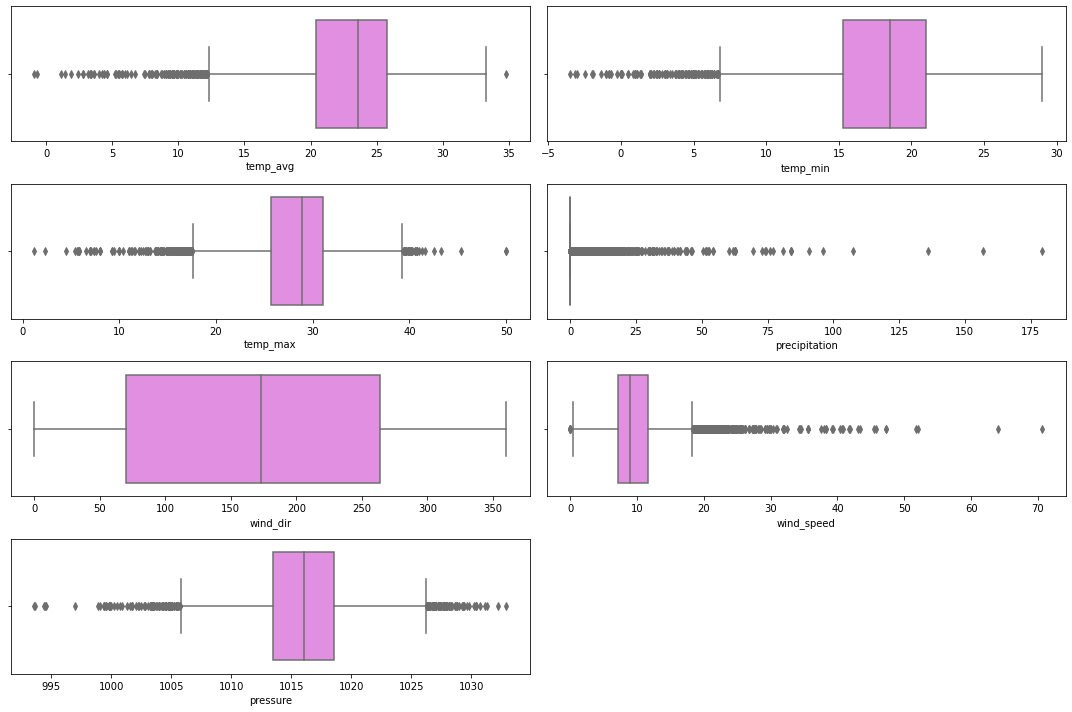

In [897]:
# Set figure characteristics.
fig, axes =plt.subplots(4,2,figsize=(15,10))

# Flatter axes to plot them easier/faster using a for loop.
axes = axes.flat

for i, col in enumerate(df_w.columns):
    sns.boxplot(x = df_w[col], data = df_w, ax=axes[i], color = "violet")

# Delete empty graph.
fig.delaxes(axes[7])

# Adjust graphs so they don't overlap.
fig.tight_layout()

# Show figures.
plt.show();

This graphs show that there are outliers in every columns excepto for wind_dir. they also show where outliers are located in each variable.

In [901]:
def get_outliers(columns_list, dataframe):
    dicc_indices = {} # create a dictionary to store indexes.

    # iterate on the weather columns list
    for col in columns_list:
        #get quartiles Q1 and Q3
        Q1 = np.nanpercentile(dataframe[col], 25)
        Q3 = np.nanpercentile(dataframe[col], 75)

        # get interquartile range (IQR)
        IQR = Q3 - Q1

        # get limits
        outlier_step = 1.5 * IQR

        # filtrate our dataframe to identify outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]

        if outliers_data.shape[0] > 0: # check if our dataframe has outliers
            dicc_indices[col] = (list(outliers_data.index))
    return dicc_indices

In [903]:
# get columns with outliers.
ind_out=get_outliers(weather_cols, df_3)
ind_out.keys()

dict_keys(['temp_avg', 'temp_min', 'temp_max', 'precipitation', 'wind_speed', 'pressure'])

### 3.2. Duplicates

Duplicates were already checked at the beggining of the project. Now it makes no sense to check for them because new rows have not been added and false duplicates can be found due to lack of some columns that added some distinguishing informtation such as 'gbifID.

In [906]:
# Check this posible mistake checking for duplicates now.
df_3.duplicated().sum()

240

240 duplicated rows were found, but if gbifID had been kept it would show that all the row has the same data except for gbifID because they were different mosquitos observed at the same time.

In [911]:
# Get a dataframe with only duplicated rows.
duplicates_data = df_3[(df_3.duplicated())]
duplicates_data.shape

(240, 15)

In [917]:
# Look for for the most repeated date.
duplicates_data['event_date'].value_counts()

2021-09-11    15
2021-09-12    11
2021-09-09    10
2021-09-08     9
2022-08-13     6
              ..
2022-05-31     1
2022-08-26     1
2022-07-10     1
2022-06-21     1
2017-06-18     1
Name: event_date, Length: 141, dtype: int64

In [919]:
# Check rows with that date to see the rest of the data.
duplicates_data[duplicates_data['event_date']=='2021-09-11']

,year,month,day,country_code,latitude,longitude,witness,temp_avg,temp_min,temp_max,precipitation,wind_dir,wind_speed,pressure,event_date
5263,2021,9,11,ES,41.53758,2.42887,Roger Eritja,22.2,17.1,28.0,1.8,252.0,8.8,1018.3,2021-09-11
5923,2021,9,11,ES,41.53759,2.42887,Roger Eritja,22.2,17.1,28.0,1.8,252.0,8.8,1018.3,2021-09-11
6521,2021,9,11,ES,41.53759,2.42887,Roger Eritja,22.2,17.1,28.0,1.8,252.0,8.8,1018.3,2021-09-11
6602,2021,9,11,ES,41.53758,2.42887,Roger Eritja,22.2,17.1,28.0,1.8,252.0,8.8,1018.3,2021-09-11
7074,2021,9,11,ES,41.53759,2.42887,Roger Eritja,22.2,17.1,28.0,1.8,252.0,8.8,1018.3,2021-09-11
7190,2021,9,11,ES,41.53759,2.42887,Roger Eritja,22.2,17.1,28.0,1.8,252.0,8.8,1018.3,2021-09-11
7686,2021,9,11,ES,41.53759,2.42887,Roger Eritja,22.2,17.1,28.0,1.8,252.0,8.8,1018.3,2021-09-11
7733,2021,9,11,ES,41.53759,2.42888,Roger Eritja,22.2,17.1,28.0,1.8,252.0,8.8,1018.3,2021-09-11
8122,2021,9,11,ES,41.53759,2.42887,Roger Eritja,22.2,17.1,28.0,1.8,252.0,8.8,1018.3,2021-09-11
8607,2021,9,11,ES,41.53759,2.42888,Roger Eritja,22.2,17.1,28.0,1.8,252.0,8.8,1018.3,2021-09-11


In [921]:
# Check the first dataframe used in this project in code1 to see the other columns that were deleted.
df_check_dupli = pd.read_csv('../data/gbif_mosquito_data.csv', sep='\t')
df_check_dupli.columns

Index(['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'infraspecificEpithet',
       'taxonRank', 'scientificName', 'verbatimScientificName',
       'verbatimScientificNameAuthorship', 'countryCode', 'locality',
       'stateProvince', 'occurrenceStatus', 'individualCount',
       'publishingOrgKey', 'decimalLatitude', 'decimalLongitude',
       'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation',
       'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day',
       'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord',
       'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber',
       'identifiedBy', 'dateIdentified', 'license', 'rightsHolder',
       'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
       'mediaType', 'issue'],
      dtype='object')

In [926]:
# Look at the same rows with the same date as before to see the rest of the information.
df_check_dupli[df_check_dupli['eventDate']=='2021-09-11T00:00:00'].sort_values('decimalLatitude')

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
14925,3496612145,1fef1ead-3d02-495e-8ff1-6aeb01123408,867d9506-358a-4914-888f-d3f8f317636d,Animalia,Arthropoda,Insecta,Diptera,Culicidae,Culex,NaN,NaN,GENUS,"Culex Linnaeus, 1758","Culex (Linnaeus, 1758)","(Linnaeus, 1758)",ES,NaN,NaN,PRESENT,NaN,7f7b1e09-01e5-4eb3-8dc0-6a3a6bea9a5c,36.03752,-5.62018,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-11T00:00:00,11,9,2021,1497010,NaN,HUMAN_OBSERVATION,CREAF,Mosquito Alert Tiger Mosquito,NaN,NaN,Roger Eritja,NaN,CC0_1_0,Mosquito Alert,Anonymous Mosquito Alert citizen scientist,NaN,NaN,2023-03-23T07:53:02.983Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES
14114,3496612956,1fef1ead-3d02-495e-8ff1-6aeb01123408,9dfc4301-91d1-4f6c-a96d-4433d93d5da8,Animalia,Arthropoda,Insecta,Diptera,Culicidae,Culex,NaN,NaN,GENUS,"Culex Linnaeus, 1758","Culex (Linnaeus, 1758)","(Linnaeus, 1758)",ES,NaN,NaN,PRESENT,NaN,7f7b1e09-01e5-4eb3-8dc0-6a3a6bea9a5c,36.03766,-5.62015,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-11T00:00:00,11,9,2021,1497010,NaN,HUMAN_OBSERVATION,CREAF,Mosquito Alert Tiger Mosquito,NaN,NaN,Roger Eritja,NaN,CC0_1_0,Mosquito Alert,Anonymous Mosquito Alert citizen scientist,NaN,NaN,2023-03-23T07:53:03.360Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES
12042,3496615028,1fef1ead-3d02-495e-8ff1-6aeb01123408,cfe2c4b6-bfbe-41cc-86ef-614ba6725bdc,Animalia,Arthropoda,Insecta,Diptera,Culicidae,Aedes,Aedes albopictus,NaN,SPECIES,"Aedes albopictus (Skuse, 1894)","Aedes albopictus (Skuse, 1895)","(Skuse, 1895)",ES,NaN,NaN,PRESENT,NaN,7f7b1e09-01e5-4eb3-8dc0-6a3a6bea9a5c,37.68382,-1.33073,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-11T00:00:00,11,9,2021,1651430,1651430.0,HUMAN_OBSERVATION,CREAF,Mosquito Alert Tiger Mosquito,NaN,NaN,Mikel Bengoa Paulis;Sarah Delacour;Ignacio Rui...,NaN,CC0_1_0,Mosquito Alert,Anonymous Mosquito Alert citizen scientist,NaN,NaN,2023-03-23T07:53:04.175Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES
6475,4052765603,1fef1ead-3d02-495e-8ff1-6aeb01123408,7513f00d-4972-4843-be82-514ed13308a1,Animalia,Arthropoda,Insecta,Diptera,Culicidae,Culex,NaN,NaN,GENUS,"Culex Linnaeus, 1758","Culex (Linnaeus, 1758)","(Linnaeus, 1758)",PT,NaN,NaN,PRESENT,NaN,7f7b1e09-01e5-4eb3-8dc0-6a3a6bea9a5c,38.71851,-9.12995,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-11T00:00:00,11,9,2021,1497010,NaN,HUMAN_OBSERVATION,CREAF,Mosquito Alert Tiger Mosquito,NaN,NaN,Carlos Barceló;Hans-Peter Fuehrer;Ognyan Mikov...,NaN,CC0_1_0,Mosquito Alert,Anonymous Mosquito Alert citizen scientist,NaN,NaN,2023-03-23T07:52:56.341Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES
14454,3496612616,1fef1ead-3d02-495e-8ff1-6aeb01123408,5e05b61d-acdc-4f96-9fcc-97f747ec0876,Animalia,Arthropoda,Insecta,Diptera,Culicidae,Aedes,Aedes albopictus,NaN,SPECIES,"Aedes albopictus (Skuse, 1894)","Aedes albopictus (Skuse, 1895)","(Skuse, 1895)",ES,NaN,NaN,PRESENT,NaN,7f7b1e09-01e5-4eb3-8dc0-6a3a6bea9a5c,39.12155,-1.83601,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-11T00:00:00,11,9,2021,1651430,1651430.0,HUMAN_OBSERVATION,CREAF,Mosquito Alert Tiger Mosquito,NaN,NaN,Sarah Delacour;Mikel Bengoa Paulis;Simone Mari...,NaN,CC0_1_0,Mosquito Alert,Anonymous Mosquito Alert citizen scientist,NaN,NaN,2023-03-23T07:52:58.513Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860,4052766218,1

Looking at the first dataframe that was used in this project it can be seen that those rows that seemed to be duplicated now have different 'gbifID' and different 'occurrenceID', so they are different mosquitoes observed.

Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


<AxesSubplot:xlabel='year', ylabel='temp_avg'>

Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


<AxesSubplot:xlabel='year', ylabel='temp_min'>

Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


<AxesSubplot:xlabel='year', ylabel='temp_max'>

Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


<AxesSubplot:xlabel='year', ylabel='precipitation'>

Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


<AxesSubplot:xlabel='year', ylabel='wind_dir'>

Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


<AxesSubplot:xlabel='year', ylabel='wind_speed'>

Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


<AxesSubplot:xlabel='year', ylabel='pressure'>

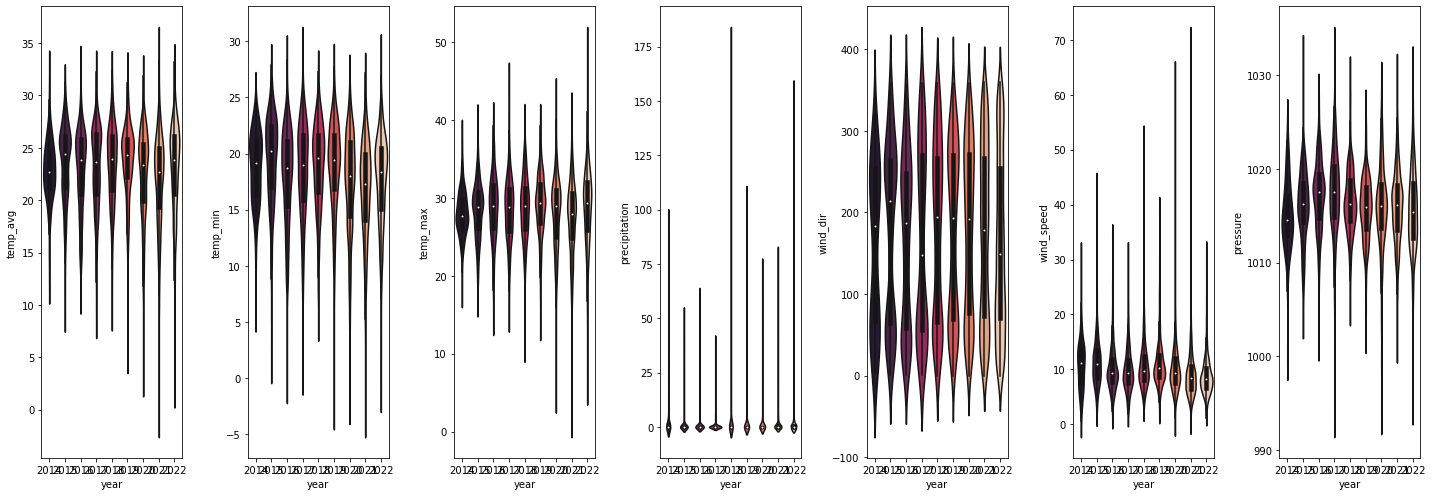

In [862]:
# Set figure characteristics.
fig, axes = plt.subplots(1, 7, figsize=(20,7))

# Create a for loop to creat one violinplot for each numerical variable.
for i in range(len(weather_columns)): 
    sns.violinplot(x='year', y=weather_columns[i], data = df_3 , ax = axes[i], palette = "rocket")   

# Adjust graphs so they don't overlap.
fig.tight_layout()

# Show figure.
plt.show()

In [853]:
# Check for outliers in month using another method.
#mean_month=df_1['month'].mean()
#std_month=df_1['month'].std()
#upper=mean_month + std_month
#lower=mean_month - std_month
#ucb=mean_month + std_month * 3
#lcb=mean_month - std_month * 3

In [854]:
## Start the graph.
#month_graph=sns.histplot(x=df_1['month'],kde=True)
#graph.axvline(x=mean_month, c='red',label='mean')
#
## Plot its standard deviation.
#graph.axvline(x=upper,c='green',label='std')
#graph.axvline(x=lower, c='green')
#
## Plot its confidence interval to 99.7%
#graph.axvline(x=lcb, c='orange',label='99 lower')
#graph.axvline(x=ucb, c='orange',label='99 upper')
#
#plt.legend()